<a href="https://colab.research.google.com/github/Rishit605/AI-Art-generation/blob/main/TensorFlow_GANs_for_Data_Generation.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Type 3 - DCGAN Completed - Custom Dataset and Image Size

In [ ]:
import tensorflow as tf
import glob
import PIL
from PIL import Image
import os
from tensorflow.keras import layers
import matplotlib.pyplot as plt

from IPython import display

In [ ]:
!pip install python-dotenv
from dotenv import load_dotenv

In [ ]:
# !touch text.env
load_dotenv()

False

In [ ]:
# # !pip install roboflow

# import os

# api_key = os.getenv("API_KEY")
# secret_key = os.getenv("SECRET_KEY")

# from roboflow import Roboflow
# rf = Roboflow(api_key=api_key)
# project = rf.workspace("majal").project("bird_detection_berkane")
# dataset = project.version(2).download("voc")

!mkdir dataset
%cd dataset

!pip install roboflow

from roboflow import Roboflow
rf = Roboflow(api_key="BE0ifvf11oGilgCsqZFj")
project = rf.workspace("dylog").project("registration-plate-vwtia")
dataset = project.version(3).download("yolov8")



/content/dataset/dataset
loading Roboflow workspace...
loading Roboflow project...
[WARNING] we noticed you are downloading a `yolov8` datasets but you don't have `ultralytics` installed. Roboflow `.deploy` supports only models trained with `ultralytics<=8.0.20`, to intall it `pip install ultralytics<=8.0.20`.

Extracting Dataset Version Zip to Registration-Plate-3 in yolov8:: 100%|██████████| 2966/2966 [00:00<00:00, 4047.13it/s]


In [ ]:
data_path = "/content/dataset/dataset/Registration-Plate-3/train/images"

In [ ]:
images = []

for filenames in os.listdir(data_path):
  # if filenames.endswith('jpg'):
    images.append(os.path.join(data_path, filenames))

In [ ]:
BATCH_SIZE = 4

# Load and preprocess the dataset
def preprocess_image(image_path):
    image = tf.io.read_file(image_path)
    image = tf.image.decode_jpeg(image, channels=3)
    image = tf.image.resize(image, [512,512])
    image = image / 255.0  # Normalize pixel values between 0 and 1
    return image

def load_dataset(image_paths):
    dataset = tf.data.Dataset.from_tensor_slices(image_paths)
    dataset = dataset.map(preprocess_image, num_parallel_calls=tf.data.AUTOTUNE)
    dataset = dataset.shuffle(1000).batch(BATCH_SIZE)
    return dataset

train_dataset = load_dataset(images)

In [ ]:
def make_generator_model():
  model = tf.keras.Sequential()
  model.add(layers.Dense(8*8*256, use_bias=False, input_shape=(100,)))
  model.add(layers.BatchNormalization())
  model.add(layers.LeakyReLU())

  model.add(layers.Reshape((8, 8, 256)))
  assert model.output_shape == (None, 8, 8, 256)

  model.add(layers.Conv2DTranspose(128, (5, 5), strides=(2,2), padding='same', use_bias=False))
  model.add(layers.BatchNormalization())
  model.add(layers.LeakyReLU())
  assert model.output_shape == (None, 16, 16, 128)

  model.add(layers.Conv2DTranspose(64, (5, 5), strides=(2,2), padding='same', use_bias=False))
  model.add(layers.BatchNormalization())
  model.add(layers.LeakyReLU())
  assert model.output_shape == (None, 32, 32, 64)

  model.add(layers.Conv2DTranspose(32, (5, 5), strides=(2,2), padding='same', use_bias=False))
  model.add(layers.BatchNormalization())
  model.add(layers.LeakyReLU())
  assert model.output_shape == (None, 64, 64, 32)

  model.add(layers.Conv2DTranspose(16, (5, 5), strides=(2,2), padding='same', use_bias=False))
  model.add(layers.BatchNormalization())
  model.add(layers.LeakyReLU())
  assert model.output_shape == (None, 128, 128, 16)

  model.add(layers.Conv2DTranspose(16, (5, 5), strides=(2,2), padding='same', use_bias=False))
  model.add(layers.BatchNormalization())
  model.add(layers.LeakyReLU())
  assert model.output_shape == (None, 256, 256, 16)

  model.add(layers.Conv2DTranspose(3, (5, 5), strides=(2,2), padding='same', use_bias=False, activation='tanh'))
  assert model.output_shape == (None, 512, 512, 3)

  return model

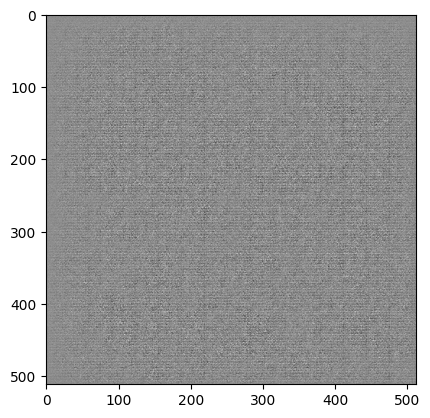

In [ ]:
generator = make_generator_model()

noise = tf.random.normal([1, 100])
generated_image = generator(noise, training=False)

plt.imshow(generated_image[0, :, :, 0], cmap='gray')

In [ ]:
generated_image.shape

TensorShape([1, 512, 512, 3])

In [ ]:
# Discriminator model
def make_discriminator_model():
    model = tf.keras.Sequential()
    model.add(layers.Conv2D(32, (4, 4), strides=(2, 2), padding='same', input_shape=[512, 512, 3]))
    model.add(layers.LeakyReLU())
    model.add(layers.Dropout(0.3))

    model.add(layers.Conv2D(64, (4, 4), strides=(2, 2), padding='same'))
    model.add(layers.LeakyReLU())
    model.add(layers.Dropout(0.3))

    model.add(layers.Conv2D(128, (4, 4), strides=(2, 2), padding='same'))
    model.add(layers.LeakyReLU())
    model.add(layers.Dropout(0.3))

    model.add(layers.Conv2D(256, (4, 4), strides=(2, 2), padding='same'))
    model.add(layers.LeakyReLU())
    model.add(layers.Dropout(0.3))

    model.add(layers.Conv2D(512, (4, 4), strides=(2, 2), padding='same'))
    model.add(layers.LeakyReLU())
    model.add(layers.Dropout(0.3))

    model.add(layers.Flatten())
    model.add(layers.Dense(1))

    return model

In [ ]:
discriminator = make_discriminator_model()
decision = discriminator(generated_image)
print (decision)

tf.Tensor([[9.3915405e-06]], shape=(1, 1), dtype=float32)


In [ ]:
decision.shape

TensorShape([1, 1])

In [ ]:
# This method returns a helper function to compute cross entropy loss
cross_entropy = tf.keras.losses.BinaryCrossentropy(from_logits=True)

In [ ]:
def discriminator_loss(real_output, fake_output):
    real_loss = cross_entropy(tf.ones_like(real_output), real_output)
    fake_loss = cross_entropy(tf.zeros_like(fake_output), fake_output)
    total_loss = real_loss + fake_loss
    return total_loss

In [ ]:
def generator_loss(fake_output):
    return cross_entropy(tf.ones_like(fake_output), fake_output)

In [ ]:
generator_optimizer = tf.keras.optimizers.Adam(1e-4)
discriminator_optimizer = tf.keras.optimizers.Adam(1e-4)

In [ ]:
checkpoint_dir = './training_checkpoints'
checkpoint_prefix = os.path.join(checkpoint_dir, "ckpt")
checkpoint = tf.train.Checkpoint(generator_optimizer=generator_optimizer,
                                 discriminator_optimizer=discriminator_optimizer,
                                 generator=generator,
                                 discriminator=discriminator)

In [ ]:
EPOCHS = 100
noise_dim = 100
num_examples_to_generate = 16

# You will reuse this seed overtime (so it's easier)
# to visualize progress in the animated GIF)
seed = tf.random.normal([num_examples_to_generate, noise_dim])

In [ ]:
# Notice the use of `tf.function`
# This annotation causes the function to be "compiled".
@tf.function
def train_step(images):
    noise = tf.random.normal([BATCH_SIZE, noise_dim])

    with tf.GradientTape() as gen_tape, tf.GradientTape() as disc_tape:
      generated_images = generator(noise, training=True)

      real_output = discriminator(images, training=True)
      fake_output = discriminator(generated_images, training=True)

      gen_loss = generator_loss(fake_output)
      disc_loss = discriminator_loss(real_output, fake_output)

    gradients_of_generator = gen_tape.gradient(gen_loss, generator.trainable_variables)
    gradients_of_discriminator = disc_tape.gradient(disc_loss, discriminator.trainable_variables)

    generator_optimizer.apply_gradients(zip(gradients_of_generator, generator.trainable_variables))
    discriminator_optimizer.apply_gradients(zip(gradients_of_discriminator, discriminator.trainable_variables))

In [ ]:
import time

def train(dataset, epochs):
  for epoch in range(epochs):
    start = time.time()

    for image_batch in dataset:
      train_step(image_batch)

    # Produce images for the GIF as you go
    display.clear_output(wait=True)
    generate_and_save_images(generator,
                             epoch + 1,
                             seed)

    # Save the model every 15 epochs
    if (epoch + 1) % 15 == 0:
      checkpoint.save(file_prefix = checkpoint_prefix)

      noise = tf.random.normal([16, 100])
      generated_images = generator(noise, training=False)
      generated_images = (generated_images * 0.5) + 0.5  # Scale the images to [0, 1]

      # Create a directory to save the generated images
      os.makedirs('generated_images', exist_ok=True)
      for i in range(generated_images.shape[0]):
          tf.keras.preprocessing.image.save_img(f'generated_images/generated_image_{epoch+1}_{i+1}.png',
                                                  generated_images[i])

    print ('Time for epoch {} is {} sec'.format(epoch + 1, time.time()-start))


  # Generate after the final epoch
  display.clear_output(wait=True)
  generate_and_save_images(generator,
                           epochs,
                           seed)

In [ ]:
def generate_and_save_images(model, epoch, test_input):
  # Notice `training` is set to False.
  # This is so all layers run in inference mode (batchnorm).
  predictions = model(test_input, training=False)

  fig = plt.figure(figsize=(4, 4))

  for i in range(predictions.shape[0]):
      plt.subplot(4, 4, i+1)
      plt.imshow(predictions[i, :, :, 0] * 127.5 + 127.5, cmap='gray')
      plt.axis('off')

  plt.savefig('image_at_epoch_{:04d}.png'.format(epoch))
  plt.show()

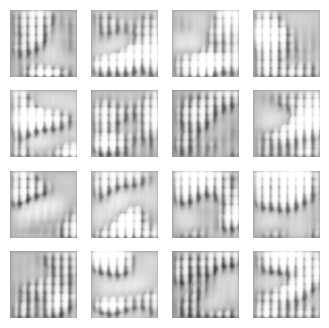

Time for epoch 9 is 29.422240018844604 sec


In [ ]:
train(train_dataset, EPOCHS)

In [ ]:
import shutil

for filenames in os.listdir('/content'):
  if filenames.endswith('png'):
    shutil.move(filenames, '/content/output')

In [ ]:
generator.save('generator_model.h5')

## Generation

In [ ]:
import tensorflow as tf

model = tf.keras.models.load_model('/content/generator_model.h5')

# Compile the model with the same configurations as before training
model.compile(optimizer='adam', loss='binary_crossentropy')

In [ ]:
import numpy as np

num_samples = 5
latent_dim = 100

# Generate random noise
noise = np.random.normal(size=(num_samples, latent_dim))

In [ ]:
generated_images = model.predict(noise)

1/1 [==============================] - 0s 92ms/step


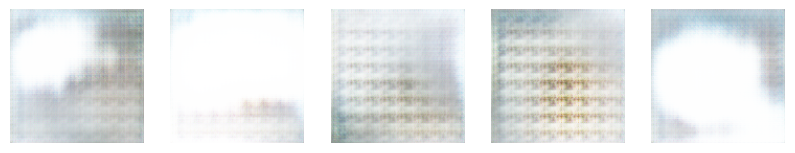

In [ ]:
generated_images = model.predict(noise)

import matplotlib.pyplot as plt

# Rescale pixel values from [-1, 1] to [0, 1]
generated_images = 0.5 * generated_images + 0.5

# Display generated images
fig, axs = plt.subplots(1, num_samples, figsize=(10, 10))
for i in range(num_samples):
    axs[i].imshow(generated_images[i])
    axs[i].axis('off')
plt.show()


---